# Chapter 7 - Moving Beyond Linearity

The topics of this chapter are:
 
 - Polynomial Regression
 - Splines
 - Generalized Addittive Models
 
Three packages are used in the examples of this chapter: ISLR, splines, gam.

---
A linear model may not be able to represent a process properly and in that case we may need to add some flexibility to the it. One of the easiest way is to add polynomials to the model 

$$y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + ... + \beta_d x_i^d + \epsilon_i$$

Models that have polynomials of the 2nd or 3rd are used often. The coefficients are computed in the same way as for the linear model, computing the least squares. A disatvantage is that a polynomial has a global effect on the full range of the predictor's domain. Other non-linear models, such as step functions and splines, allow to split the predictor domain so that different models are used in each subdomain.  

Here is a simple example of how we can fit a data set using a quadratic polynomial in R. Polynomials can form a set of orthonormal functions

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-5421.2466887,1.546580e+03,-3.505313,0.0006921695
"poly(x, 2, raw = TRUE)1",77.7075083,2.197402e+01,3.536336,0.0006240344
"poly(x, 2, raw = TRUE)2",-0.2784125,7.805107e-02,-3.567055,0.0005628472


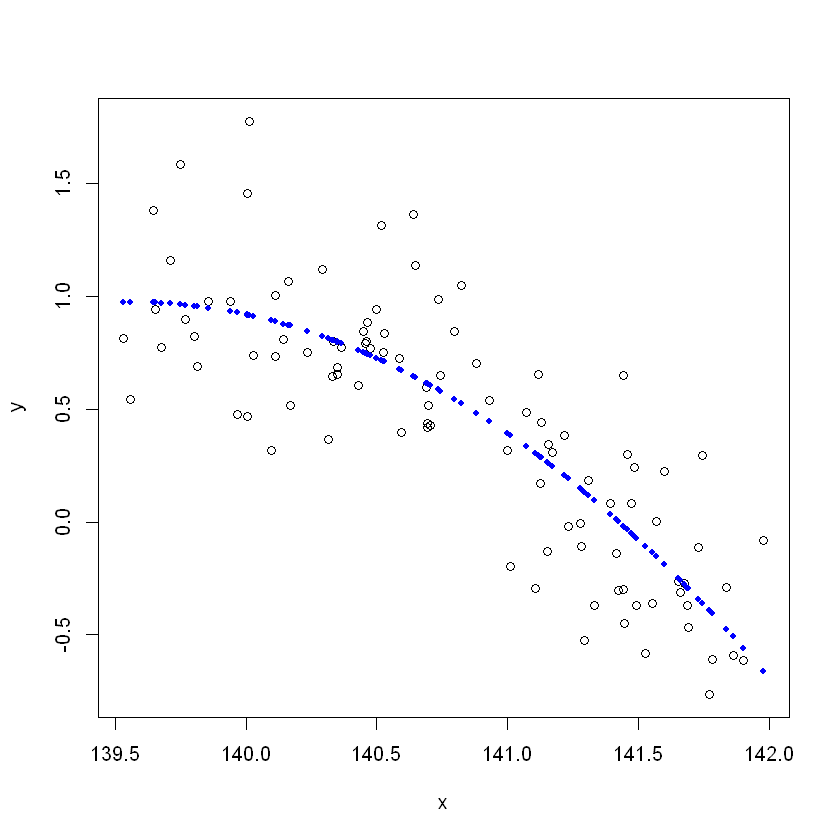

In [1]:
load("data/7.R.RData")
fit <- lm(y ~ poly(x, 2, raw = TRUE)) # raw = TRUE selects a base of x,x^2 instead of orthogonal polynomials  
coef(summary(fit))
plot(y ~ x) # plot the data
points(x, fitted(fit), col ='blue', pch=20) # plot the fit for each value of the predictor

### 7.8.1 Polynomial Regression and Step Functions
We will use the Wage data set for our examples about polynomial regression and step functions. We want to see how wage depends on the other variables.

In [3]:
library(ISLR)
dim(Wage); names(Wage)

[1] 3000   11

[1] "year"       "age"        "maritl"     "race"       "education" 
 [6] "region"     "jobclass"   "health"     "health_ins" "logwage"   
[11] "wage"

In [4]:
fit <- lm(wage ~ poly(age, 4), data = Wage) # fit of a 4-degree polynomial
coefficients(summary(fit))

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),111.70361,0.7287409,153.283015,0.000000e+00
"poly(age, 4)1",447.06785,39.9147851,11.200558,1.484604e-28
"poly(age, 4)2",-478.31581,39.9147851,-11.983424,2.355831e-32
"poly(age, 4)3",125.52169,39.9147851,3.144742,1.678622e-03
"poly(age, 4)4",-77.91118,39.9147851,-1.951938,5.103865e-02


Now we plot the data and the fit for each value of the predictor. This is just a quick plot because usually we are interested in using the fit with a grid that may have different limits and number of points than the original predictor. 

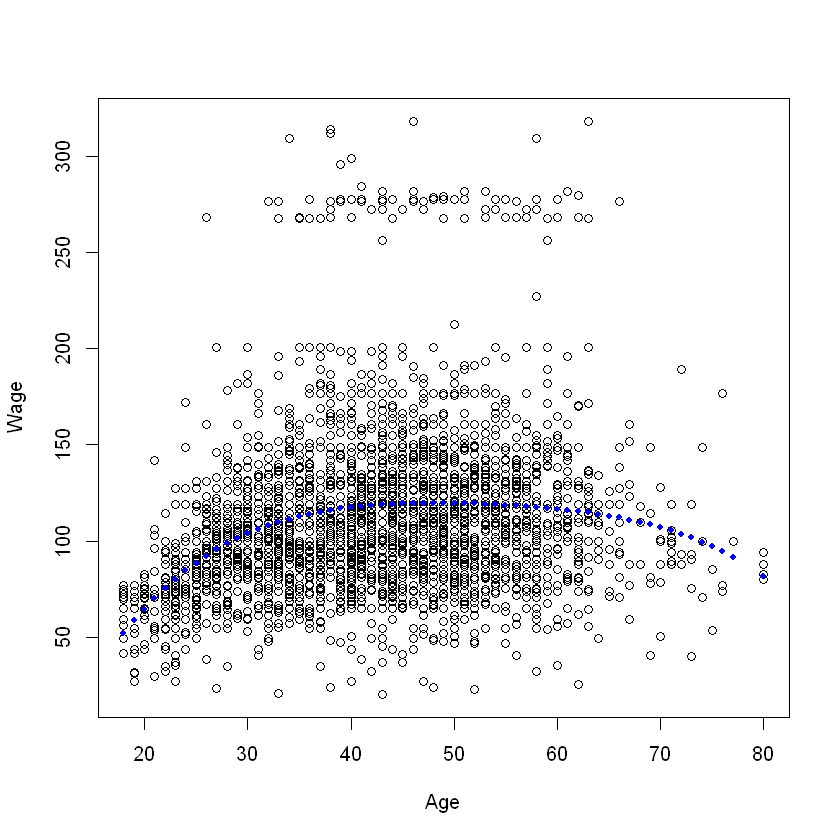

In [5]:
plot(Wage$wage ~ Wage$age, xlab = "Age", ylab = "Wage")
points(Wage$age, fitted(fit), col ='blue', pch=20)

Now we define a grid for the age variable. In this case we set the same limits as in the original data set and we use the default step, one, since the age is given as integers. Once we have the grid we use the predict() function and the fit to compute the response of the model for each point of the grid and finally we plot the fit with the standard error.

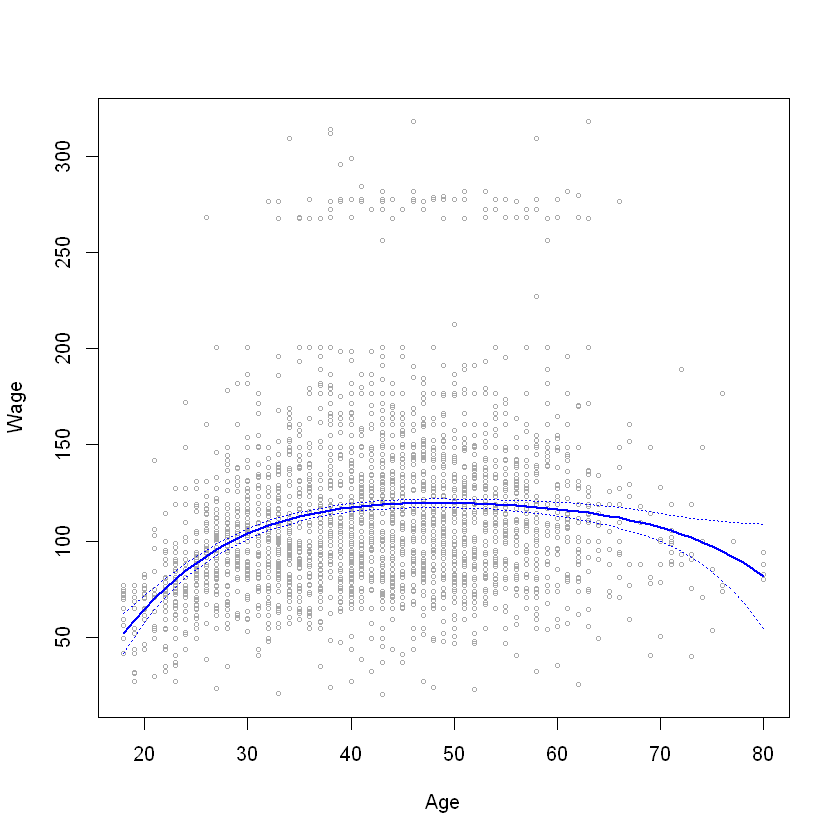

In [6]:
age_interval <- range(Wage$age) # lower and upper limits of the predictor
age.grid <- seq(from = age_interval[1], to = age_interval[2]) # builds the grid
preds <- predict(fit, newdata = list(age = age.grid), se = TRUE) # compute the prediction for the grid points
#par(mfrow = c(1,2), mar = c(4.5, 4.5, 1, 1), oma = c(0, 0, 4, 0)) # set the frame of the plot
plot(Wage$age, Wage$wage, xlim = age_interval, cex = 0.5, col = "darkgrey", xlab = "Age", ylab = "Wage") # plot the data points
lines(age.grid, preds$fit, lwd = 2, col = "blue") # adds the fit to the data points
se.bands <- cbind(preds$fit + 2 * preds$se.fit, preds$fit - 2 * preds$se.fit) # defines the curves of the standard error
matlines(age.grid, se.bands, lwd = 1, col = "blue", lty = 3) # adds the standard error

#### Analysis of Variance (ANOVA F-test)
We fit models of increasing degree polynomials and then we compare them to look for the simplest one that fits the data well enough. The models are nested, the one with higher degree containing those with lower degree. The anova() function tests the null hypothesis: the simpler model is sufficient to explain the data. A low p-value means that the test is significant and the null hyphotesis is false, that is, the simpler model cannot explain the data. A p-value not very small means that the null hypothesis is true and the simpler model can explain the data (see chapter 3 for an explanation of the ANOVA F-test).

In [7]:
fit1 <- lm(wage ~ age, data = Wage)
fit2 <- lm(wage ~ poly(age, 2), data = Wage)
fit3 <- lm(wage ~ poly(age, 3), data = Wage)
fit4 <- lm(wage ~ poly(age, 4), data = Wage)
fit5 <- lm(wage ~ poly(age, 5), data = Wage)
anova(fit1, fit2, fit3, fit4, fit5)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
2998,5022216,NA,NA,NA,NA
2997,4793430,1,228786.010,143.5931074,2.367734e-32
2996,4777674,1,15755.694,9.8887559,1.679213e-03
2995,4771604,1,6070.152,3.8098134,5.104623e-02
2994,4770322,1,1282.563,0.8049758,3.696820e-01


The last row is the result of the comparison between the 4-degree and the 5-degree models and being the p-value, Pr(>F), not very small it means that the null hypothesys is not false and the model with 4 degree can explain the data.

#### Logistic regression
From the plot we see that there are two distinct groups, those who earn more than 250K, and those who earn less than 200K. We may be interested in predicting to which group an individual can belong. We train the logit model 

$$log(\frac{Pr(y_i=1|x_i)}{1 - Pr(y_i=1|x_i)}) = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + ... + \beta_d x_i^d $$

In [8]:
fit <- glm(I(wage > 250) ~ poly(age, 4), data = Wage, family = "binomial")
preds <- predict(fit, newdata = list(age = age.grid), se = TRUE)

In order to get the probability of earning more than 250K we have to transform the logit

$$Pr(y_i = 1|x_i) = \frac{exp(\beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + ... + \beta_d x_i^d)}{1 + exp(\beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + ... + \beta_d x_i^d)}$$

and then compute the values of the fit for each x value in the grid with the standard errors.

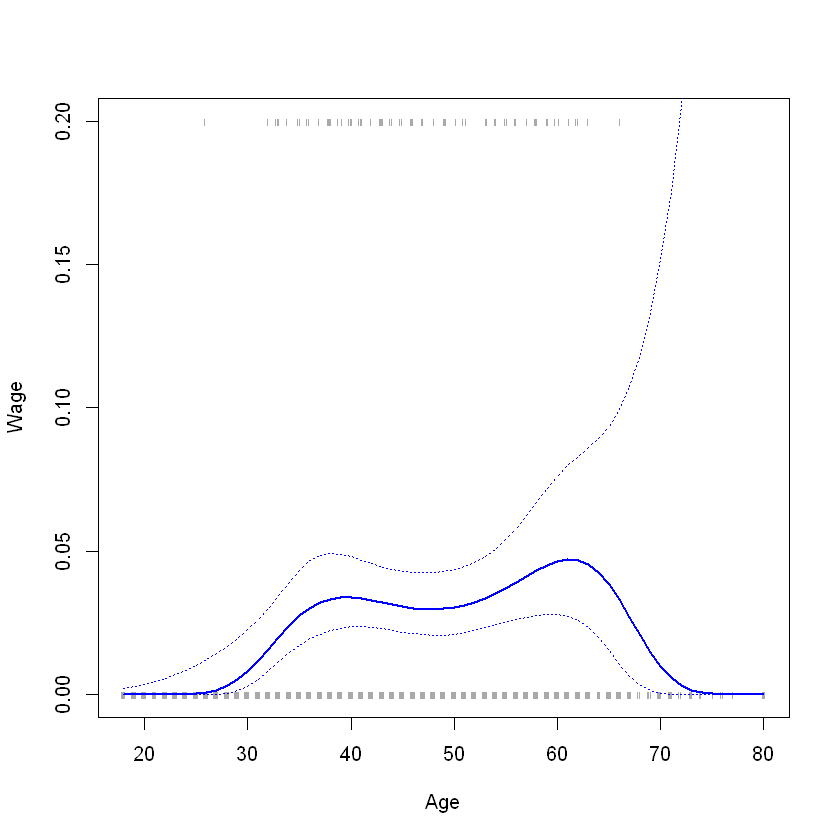

In [9]:
pfit <- exp(preds$fit) / (1 + exp(preds$fit))
se.bands.logit <- cbind(preds$fit + 2 * preds$se.fit, preds$fit - 2 * preds$se.fit)
se.bands <- exp(se.bands.logit) / (1 + exp(se.bands.logit))
plot(Wage$age, Wage$wage, xlim = age_interval, type = "n", ylim = c(0, 0.2), xlab = "Age", ylab = "Wage")
points(jitter(Wage$age), I((Wage$wage > 250) / 5), cex = 0.5, pch = "l", col = "darkgrey")
lines(age.grid, pfit, lwd = 2, col = "blue")
matlines(age.grid, se.bands, lwd = 1, col = "blue", lty = 3)

#### Step Functions
Changing the degree of a polynomial function has an inpact on all its domain. We can fit the data using constant functions on different intervals of the domain.  

$$y_i = \beta_0 + \beta_1 C_1(x_i) + \beta_2 C_2(x_i) + \beta_3 C_3(x_i) + ... + \beta_K C_K(x_i) + \epsilon_i$$

where each C_k(X) = 1 only in an interval $c_{k-1} \leq X \leq c_k$ and zero elsewhere. We start by splitting the domain, age in our example, in 4 intervals using the cut() function and putting each age value in the intervals it belongs. 

In [10]:
table(cut(Wage$age, 4))


(17.9,33.5]   (33.5,49]   (49,64.5] (64.5,80.1] 
        750        1399         779          72 

In [11]:
fit <- lm(wage ~ cut(age, 4), data = Wage)
coefficients(summary(fit))

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),94.158392,1.476069,63.789970,0.000000e+00
"cut(age, 4)(33.5,49]",24.053491,1.829431,13.148074,1.982315e-38
"cut(age, 4)(49,64.5]",23.664559,2.067958,11.443444,1.040750e-29
"cut(age, 4)(64.5,80.1]",7.640592,4.987424,1.531972,1.256350e-01


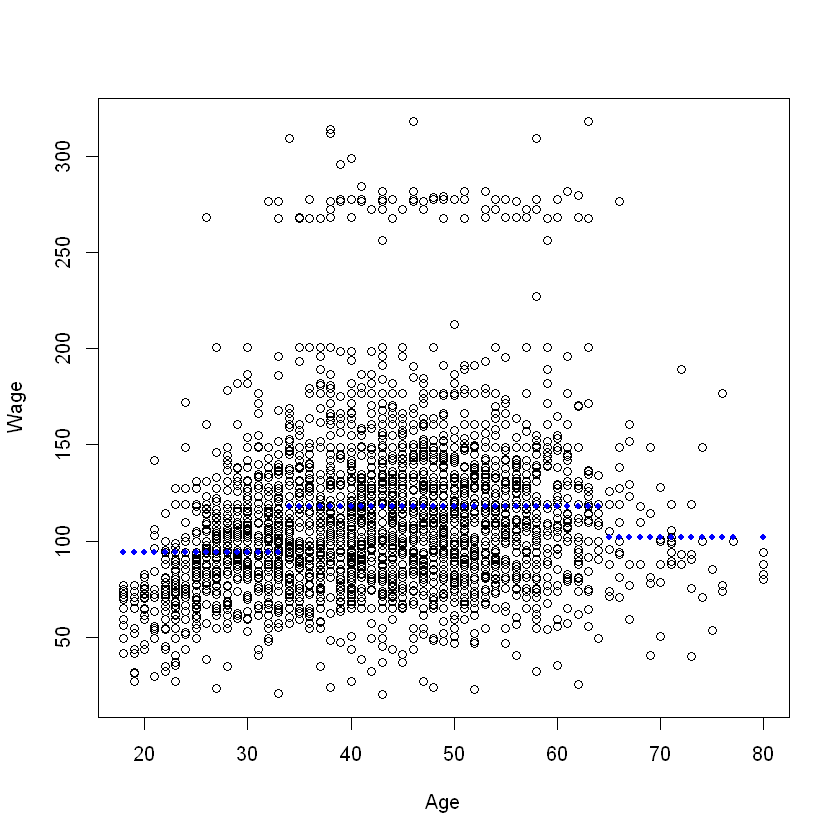

In [12]:
plot(Wage$age, Wage$wage, xlab = "Age", ylab = "Wage")
points(Wage$age, fitted(fit), col ='blue', pch=20)

### 7.8.2 Splines
Instead of using constant functions in each interval in which we have divided a domain, we can use polynomials as basis functions. For example in cubic splines we have a function of three degree polynomials, $x,x^2, x^3$ and a constant to which we add a polynomial term for each knot so that we have 4 + K coefficients that can be fit using least squares  

$$y_i = \beta_0 + \beta_1 b_1(x_i) + \beta_2 b_2(x_i) + \beta_3 b_3(x_i) + ... + \beta_{K+3} b_{K+3}(x_i) + \epsilon_i$$

Naturally we have to add some constraints to the polynomial so that it is continuous at the knots $c_k$ and also its 1st and 2nd derivatives are continuous. The function bs() from the package 'splines' generates the basis functions and the knots. As an example we fit a function of 7 degrees of freedom 

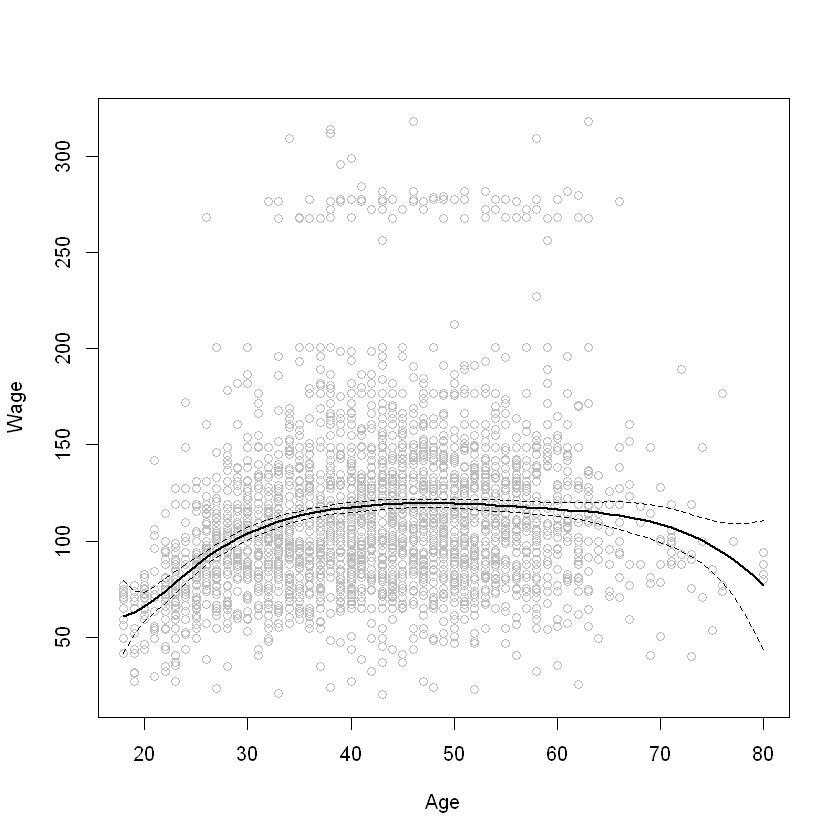

In [13]:
library(splines)
fit <- lm(wage ~ bs(age, degree = 3, knots = c(25, 40, 60)), data = Wage) # generates the basis functions and fits the polynomial
pred <- predict(fit, newdata = list(age = age.grid), se = TRUE) # make predictions for each value of the grid
plot(Wage$age, Wage$wage, col = "gray", xlab = "Age", ylab = "Wage") # plots the data points
lines(age.grid, pred$fit, lwd = 2) # plots the fit
lines(age.grid, pred$fit + 2 * pred$se, lty = "dashed") # standard error for each prediction 
lines(age.grid, pred$fit - 2 * pred$se, lty = "dashed") # lower standard error for each prediction

Another useful function is ns() for creating natural splines that adds a constraint so that the polynomial is linear at the boundary of the domain. The ns() function creates the knots from the degrees of freedom (knots = df - 2).

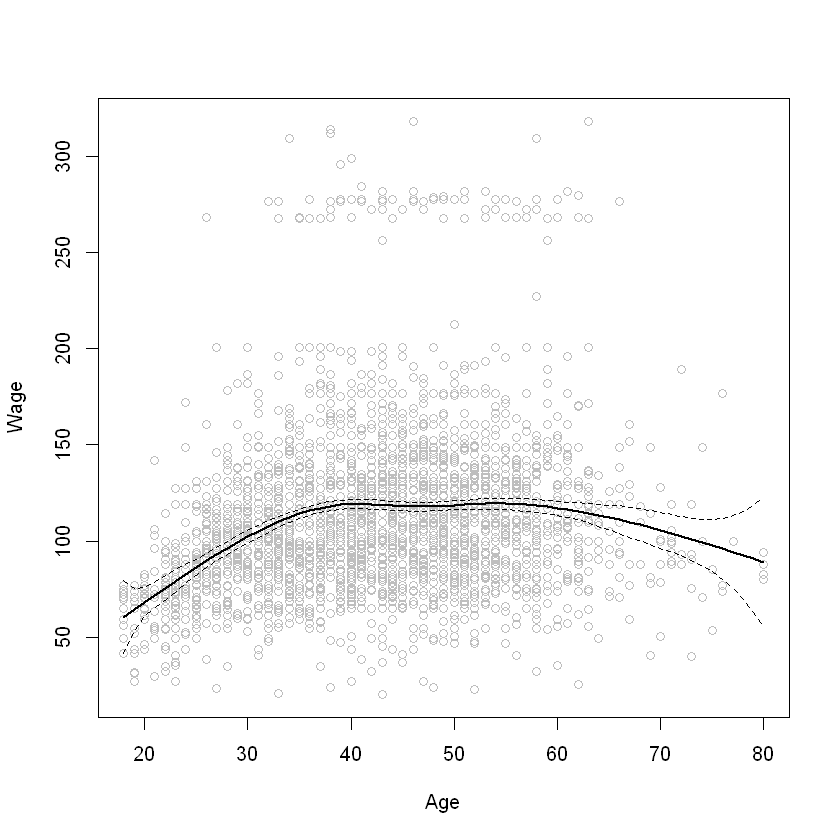

In [14]:
fit2 <- lm(wage ~ ns(age, df = 5), data = Wage) # generates the basis functions and fits the polynomial
pred2 <- predict(fit2, newdata = list(age = age.grid), se = TRUE) # make predictions for each value of the grid
plot(Wage$age, Wage$wage, col = "gray", xlab = "Age", ylab = "Wage") # plots the data points
lines(age.grid, pred2$fit, lwd = 2) # plots the fit
lines(age.grid, pred2$fit + 2 * pred$se, lty = "dashed") # standard error for each prediction 
lines(age.grid, pred2$fit - 2 * pred$se, lty = "dashed") # lower standard error for each prediction

### 7.8.3 Generalized Addittive Models (GAMs)
We extend the univariate examples seen so far to include non-linear terms to a predictor, to the case of multiple predictors. We will deal with addittive models, that is, models in which predictors do not have interactions and can be represented as follows

$$y_i = \beta_0 + f_1(x_{i1}) + f_2(x_{i2}) + .. + f_p(x_{ip})$$

where p is the number of predictors and $f_j(x_{ij})$ are fuctions that represent the impact of the predictor j on the repsonse that can be fit with any of the techniques that we have seen so far. The advantage of GAMs is that they allow for more than one predictors to be taken into account for a response variable and the impact of each predictor can be easily seen. This advantage is also a limitation because these models cannot account for any interaction that might exists among the predictors.  

As an example we fit a GAM to predict wage using 'year', 'age' and 'education' as predictors. We set year as a polynomial function with 4 degrees of freedom, age with 5 and education as a dummy variable. In the plot we can see the impact of these three predictors on wages.

Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"

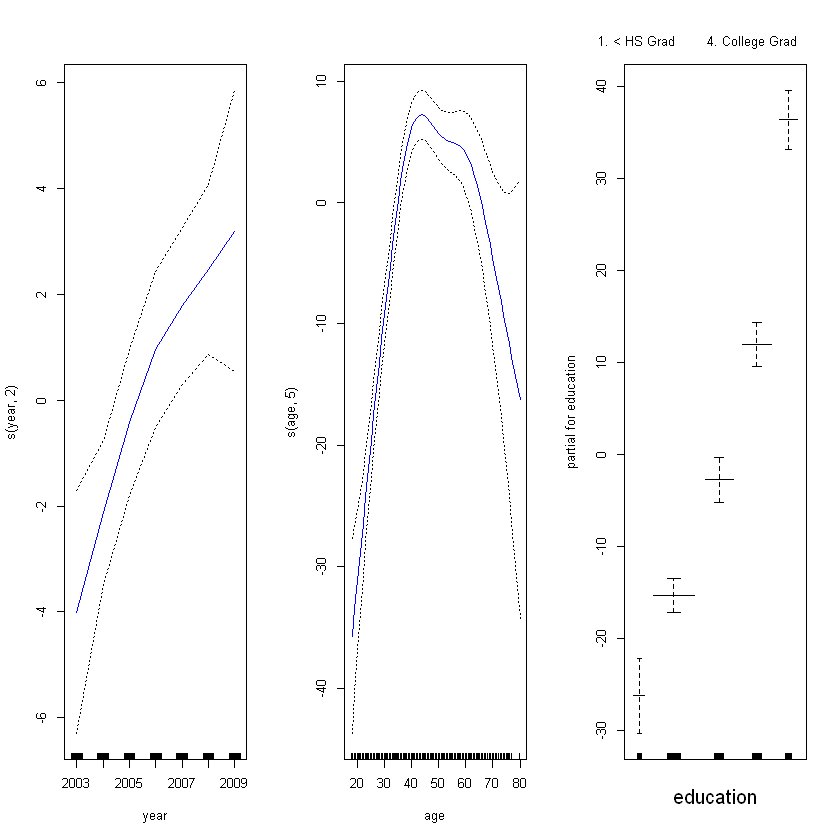

In [16]:
library(gam)
gam.m3 <- gam(wage ~ s(year, 2) + s(age, 5) + education, data = Wage)
par(mfrow = c(1,3))
plot(gam.m3, se = TRUE, col = "blue")

Since in the GAM the predictors do not interact we can easily perform the model selection test, for example usin ANOVA F-test, for each of them against the response variable. 